# Test Problem 2: Diffusion of a Gaussian function

Author: Jørgen S. Dokken

Let us now solve a more interesting problem, namely the diffusion of a Gaussian hill. We take the initial value to be 
\begin{align}
    u_0(x,y)&= e^{-ax^2-ay^2}
\end{align}
for $a=5$ on the domain $[-2,-2]\times[2,2]$. For this problem we will use homogeneous Dirichlet boundary conditions ($u_D=0$).

The first difference from the previous problem is that we are not using a unit square. We create the rectangular domain with `dolfinx.RectangleMesh`.

In [1]:
import dolfinx
import numpy as np
from dolfinx.cpp.mesh import CellType
from mpi4py import MPI
from petsc4py import PETSc

# Define temporal parameters
t = 0 # Start time
T = 2.0 # Final time
num_steps = 61     
dt = T / num_steps # time step size

# Define mesh
nx, ny = 50, 50
mesh = dolfinx.RectangleMesh(MPI.COMM_WORLD, [np.array([-2, -2, 0]), np.array([2, 2, 0])], [nx, ny], CellType.triangle)
V = dolfinx.FunctionSpace(mesh, ("CG", 1))

Note that we have used a much higher resolution that before to better resolve features of the solution. 
We also easily update the intial and boundary conditions. Instead of using a class to define the initial condition, we simply use a function

In [2]:
# Create initial condition
def initial_condition(x):
    a = 5
    return np.exp(-a*(x[0]**2+x[1]**2))
u_n = dolfinx.Function(V)
u_n.name = "u_n"
u_n.interpolate(initial_condition)
u_n.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

# Create boundary condition
u_D = dolfinx.Function(V)
u_D.vector.set(0)
fdim = mesh.topology.dim - 1
boundary_facets = dolfinx.mesh.locate_entities_boundary(
    mesh, fdim, lambda x: np.full(x.shape[1], True, dtype=np.bool))
bc = dolfinx.DirichletBC(u_D, dolfinx.fem.locate_dofs_topological(V, fdim, boundary_facets))

## Time-dependent output
To visualize the solution in an external program such as Paraview, we create a an `XDMFFile` which we can store multiple solutions in. The main advantage with an XDMFFile, is that we only need to store the mesh once, and can append multiple solutions to the same grid, reducing the storage space.
The first argument to the XDMFFile is which communicator should be used to store the data. As we would like one output, independent of the number of processors, we use the `COMM_WORLD`. The second argument is the file name of the output file, while the third argument is the state of the file, 
this could be read (`"r"`), write (`"w"`) or append (`"a"`).

In [3]:
from dolfinx.io import XDMFFile
xdmf = XDMFFile(MPI.COMM_WORLD, "diffusion.xdmf", "w")
xdmf.write_mesh(mesh)
# Define solution variable, and interpolate initial solution for visualization in Paraview
uh = dolfinx.Function(V)
uh.name = "uh"
uh.interpolate(initial_condition)
uh.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
xdmf.write_function(uh, t)

## Variational problem and solver
As in the previous example, we prepare objects for time dependent problems, such that we do not have to recreate data-structures.

In [4]:
# Define variational problem
import ufl
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
f = dolfinx.Constant(mesh, 0)
F = u*v*ufl.dx + dt*ufl.dot(ufl.grad(u), ufl.grad(v))*ufl.dx - (u_n + dt*f)*v*ufl.dx
a = ufl.lhs(F)
L = ufl.rhs(F)
# Compute matrix and vector for linear algebra problem
import dolfinx.fem
A = dolfinx.fem.assemble_matrix(a, bcs=[bc])
A.assemble()
b = dolfinx.fem.assemble_vector(L)
b.set(0)

# Create solver
solver = PETSc.KSP().create(mesh.mpi_comm())
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

## Solve time-dependent problem

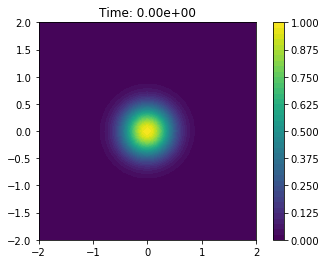

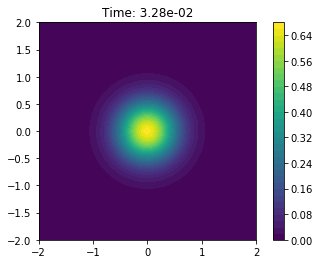

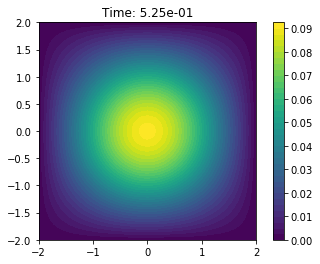

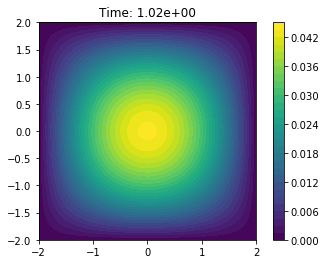

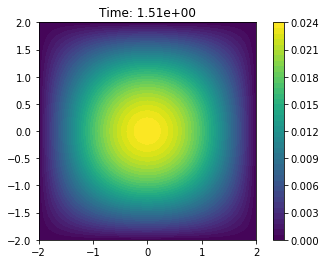

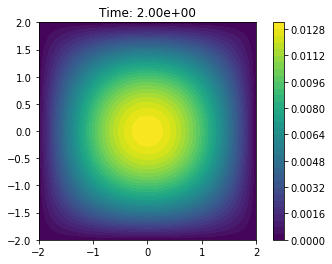

In [5]:
%matplotlib inline
import dolfinx.plotting
import matplotlib.pyplot as plt
# Define minimum and maximum values for plotting
min_color = min(u_n.vector.array)
max_color = max(u_n.vector.array)
c = dolfinx.plotting.plot(u_n,vmin=min_color, vmax=max_color, title="Time: {0:.2e}".format(t))
plt.colorbar(c)
plt.show()
# Prepare for animation plot
fig = plt.figure()
for i in range(num_steps):
    t += dt

    # Update the right hand side reusing the initial vector
    b.set(0)
    dolfinx.fem.assemble_vector(b, L)
    
    # Apply Dirichlet boundary condition to the vector
    dolfinx.fem.apply_lifting(b, [a], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    dolfinx.fem.set_bc(b, [bc])

    # Solve linear problem
    solver.solve(b, uh.vector)
    
    # Update solution at previous time step (u_n)
    uh.vector.copy(result=u_n.vector)
    # Write solution to file
    xdmf.write_function(uh, t)
    # Plot every 20th time step
    if i % 15 == 0:
        min_color = min(uh.vector.array)
        max_color = max(uh.vector.array)
        c = dolfinx.plotting.plot(uh,vmin=min_color, vmax=max_color, title="Time: {0:.2e}".format(t))
        plt.colorbar(c)
        plt.show()

xdmf.close()

## Animation with Paraview
We can also use Paraview to create an animation. We open the file in paraview with `File->Open`, and then press `Apply` in the properties panel.

Then, we add a time-annotation to the figure, pressing: `Sources->Alphabetical->Annotate Time` and `Apply` in the properties panel. It Is also a good idea to select an output resolution, by pressing `View->Preview->1280 x 720 (HD)`.

Then finally, click `File->Save Animation`, and save the animation to the desired format, such as `avi`, `ogv` or a sequence of `png`s. Make sure to set the framerate to something, sensible, in the range of $5-10$ frames per second.